*This notebook was created by [Sergey Tomin](http://www.xfel.eu/organization/staff/tomin_sergey/) which was inspired by questions from E.R. Source and license info is on [GitHub](https://github.com/iagapov/ocelot/tree/dev/docs). June 2017.* 

## Tutorial N7. Lattice design. Matching. Twiss back tracking.
### Outline
* FODO lattice (undulator section) with desiring max and min twiss parameters. 
* Back tracking through chicanes 
* Matching of twiss parameters in matching sections

### Introduction 
In this tutorial we are going to design the simplest FEL lattice for external seeding option. 
The desire lattice is:
- matching section - modulator - chicane - modulator - chicane - FODO.

FODO in that case is undulator section:
- undulator - QF - undulator - QD - undulator - QF - .... 

where QF, QD - focusin and defocusing quadrupoles. 

**And suppose we know**: 
1. max and min values for the betas in the undulator section.
2. chicanes geometry and parameters are defined.  
3. twiss parameters on the entrance of the matching section. 

We can solve this task in many ways (and even more simply), *but to cover all topics we will do it in a few steps*:

1. the matching of twiss parameters in FODO lattice to find desired amplitudes of the beta functions. 
2. back tracking of the beta through *modulator - chicane - modulator - chicane* 
3. matching quadrupoles in the matching section


#### Optics design and matching

Optics design is the art (still) and a few people in the world can do really good design (and author of this notebook is not one of them (so far :)). 

The matching techniques barely help you if your initial geometry or initial conditions are poor. In this example, we are not aiming to make a good design but just show an example of usage some matching functions. 

In [1]:
# the output of plotting commands is displayed inline within 
# frontends, directly below the code cell that produced it.
%matplotlib inline

from time import time 

# this python library provides generic shallow (copy) 
# and deep copy (deepcopy) operations 
from copy import deepcopy

# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *


initializing ocelot...


## Step 1. FODO lattice matching 
### Design the simplest FODO lattice

In [2]:
# example of the FODO
U = Undulator(nperiods=50, lperiod=0.04, Kx=1)
D = Drift(l=0.5)
QF = Quadrupole(l=0.25, k1=1)
QD = Quadrupole(l=0.25, k1=-1)

M1 = Marker()
cell = (M1, QF, D, U, D, QD, QD, D, U, D, QF)

# suppose we have 5 cells or 10 undulators
fodo = cell*5

### Periodic solution for FODO lattice
**Note**

* In the most cases to find twiss periodical solution we do not need to put the initial conditions and we can use following command to calculate twiss parameters:
**tws = twiss(lat)** 

**BUT**

* To take into account undulator vertical focusing effect we have to define the energy of the electron beam. and in that case we have to define initial condition like that: 


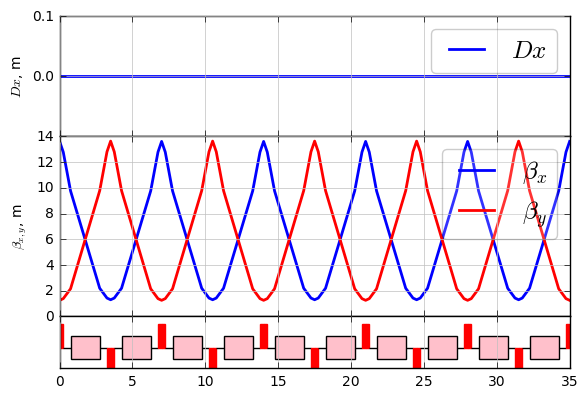

In [3]:
# create MagneticLattice object
lat_fodo = MagneticLattice(fodo)

tws0 = Twiss()
# by default the all parameters are zero and 
# that what we need to force the twiss function 
# to calculate periodic solution

# print(tws0)

# And we need to define the beam energy
tws0.E = 1 # GeV

tws = twiss(lat_fodo, tws0=tws0)

plot_opt_func(lat_fodo, tws, legend=False)
plt.show()

### Matching

initial value: x =  [1, -1]
Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 41
         Function evaluations: 80
QF.k1 =  1.07104011822
QD.k1 =  -0.857945636259


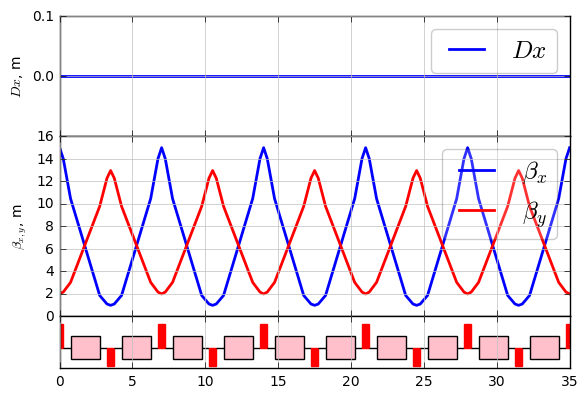

In [4]:
# constrains
constr = {M1:{'beta_x':15, 'beta_y':2}, 'periodic':True}

# variables
vars = [QF, QD]

# initial condition for twiss
tw0=tws[-1]

match(lat_fodo, constr, vars, tw0, verbose=False)

# results 
print("QF.k1 = ", QF.k1)
print("QD.k1 = ", QD.k1)


tws0=Twiss()
tws0.E = 1 # GeV

tws = twiss(lat_fodo, tws0=tws0)

# let's variable *tws_fodo* will be the twiss 
# parameters on the FODO entrance 
tws_fodo = tws[-1]

plot_opt_func(lat_fodo, tws, legend=False)
plt.show()

## Step 2. Chicanes. 

In [5]:
# undulator + chicane + undulator + chicane
modulator = Undulator(nperiods=10, lperiod=0.1, Kx = 2)

# Chicane from CSR example with small modifications 

b1 = Bend(l = 0.5, angle=-0.0336, e1=0.0, e2=-0.0336, gap=0, tilt=0, eid='BB.393.B2')
b2 = Bend(l = 0.5, angle=0.0336, e1=0.0336, e2=0.0, gap=0, tilt=0,  eid='BB.402.B2')
b3 = Bend(l = 0.5, angle=0.0336, e1=0.0, e2=0.0336, gap=0, tilt=0, eid='BB.404.B2')
b4 = Bend(l = 0.5, angle=-0.0336, e1=-0.0336, e2=0.0, gap=0, tilt=0, eid='BB.413.B2')

d = Drift(l=1.5/np.cos(b2.angle))

start_csr = Marker()
stop_csr = Marker()

# define chicane frome the bends and drifts
chicane = [start_csr, Drift(l=1), b1, d, b2, 
           Drift(l=1.5), b3, d, b4, Drift(l= 1.), stop_csr]


# For sake of buity add randomly couple of the quadrupoles

D1 = Drift(l=0.5)
echo = (D1, QF, D1, modulator, D1, QD, chicane,  QF, D1, modulator,D1, QD, chicane)


#### Chicane parameters
For example, one wants to know R56 of the whole chicane. It can be easily calculated

In [6]:
lat_chic = MagneticLattice(chicane)
# in that case energy is not important we do not have 
# energy dependant elements here
R = lattice_transfer_map(lat_chic, energy=0)
print("R56 = ", R[4,5]*1000, "mm")

R56 =  -4.14432493493 mm


### Backtracking though chicanes.
We know twiss parameters on the entrance of the FODO
but for backtracking we need to 
* invert alphas 
* and invert the lattice (change the order of the element)

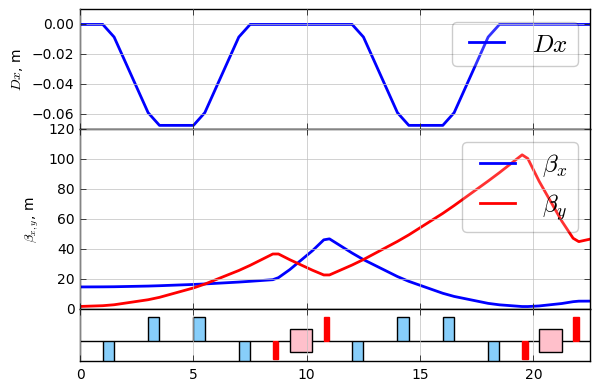

In [7]:
# inverting alphas

tws2 = Twiss()
tws2.alpha_x = -tws_fodo.alpha_x
tws2.alpha_y = -tws_fodo.alpha_y
tws2.beta_x = tws_fodo.beta_x
tws2.beta_y = tws_fodo.beta_y

# invert the lattice
echo_inv = echo[::-1]
lat_echo_inv = MagneticLattice(echo_inv)

# calculate twiss 
tws_echo = twiss(lat_echo_inv, tws0=tws2)
tws_echo_inv_end = tws_echo[-1]

# show the twiss parameters of INVERTED echo
plot_opt_func(lat_echo_inv, tws_echo, legend=False)
plt.show()

So twiss parameters on the entrance of the echo lattice are: 

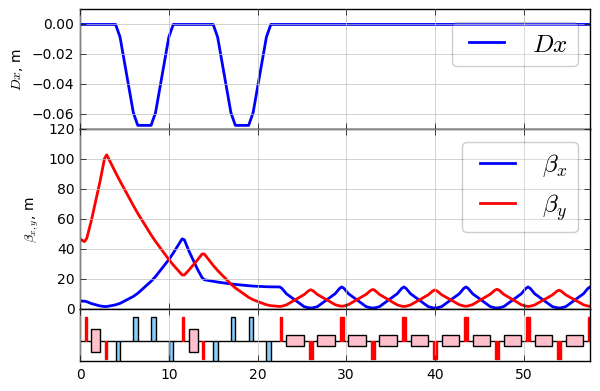

In [8]:
# inverting alphas again is needed
tws_e = Twiss()
tws_e.beta_x = tws_echo_inv_end.beta_x
tws_e.beta_y = tws_echo_inv_end.beta_y
tws_e.alpha_x = -tws_echo_inv_end.alpha_x
tws_e.alpha_y = -tws_echo_inv_end.alpha_y

lat_echo_fodo = MagneticLattice((echo, fodo) )

tws_all = twiss(lat_echo_fodo, tws_e)

plot_opt_func(lat_echo_fodo, tws_all, legend=False)
plt.show()

## Step 3.  Matching section

In [9]:
Q1 = Quadrupole(l=0.3, k1=1)
Q2 = Quadrupole(l=0.3, k1=1)
Q3 = Quadrupole(l=0.3, k1=1)
Q4 = Quadrupole(l=0.3, k1=1)


m1 = Marker()
m2 = Marker()
dm = Drift(l=1.5)
match_sec = (m1, dm, Q1, dm, Q2, dm, Q3, dm, Q4, dm, m2)

lat_m = MagneticLattice(match_sec[::-1])

#### Matching
As it was mentioned above, matching will not give you desired values if your geometry of initial conditions are poor. Because our goal is not a good design but showing the concept of OCELOT usage, we choose very relax condition. 
Twiss parameters on the entrance of the matching section:

- beta_x = 5 
- beta_y = 5
- alpha_x = not defined
- alpha_y = not defined

the twiss parameters on the exit of matching section are defined by echo section

initial value: x =  [1, 1, 1, 1]
Optimization terminated successfully.
         Current function value: 214921323.823277
         Iterations: 106
         Function evaluations: 197
Q1.k1 =  2.35585335163
Q2.k1 =  -1.31552921354
Q3.k1 =  -0.916460317653
Q4.k1 =  1.33264967947


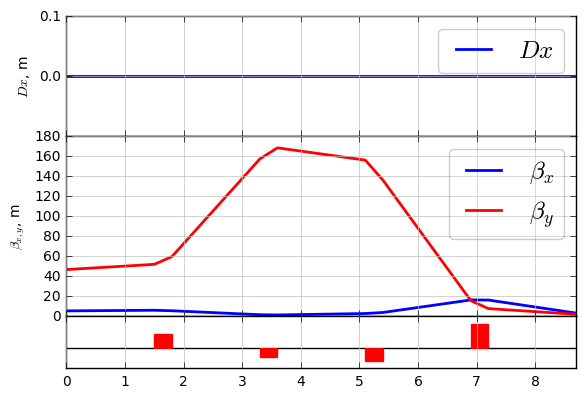

In [10]:
# constrains
constr = {m1:{'beta_x':5, 'beta_y':5}, 
          m2:{'beta_x':tws_e.beta_x, 'beta_y':tws_e.beta_y, 
              'alpha_x': -tws_e.alpha_x, "alpha_y":-tws_e.alpha_y}}

# variables
vars = [Q1, Q2, Q3,Q4]

# initial condition for twiss

match(lat_m, constr, vars, tw0, verbose=False)

for i, q in enumerate(vars):
    print("Q"+str(i+1)+".k1 = ", q.k1)

tws0 = Twiss()
tws0.beta_x = tws_e.beta_x
tws0.beta_y = tws_e.beta_y
tws0.alpha_x = -tws_e.alpha_x
tws0.alpha_y = -tws_e.alpha_y

tws = twiss(lat_m, tws0)
plot_opt_func(lat_m, tws, legend=False)
plt.show()

tws0 = tws[-1]
tws0.alpha_x = -tws[-1].alpha_x
tws0.alpha_y = -tws[-1].alpha_y

## FINAL Lattice

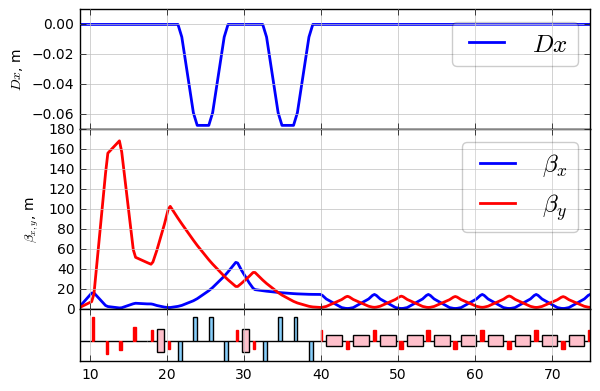

In [11]:
cell = (match_sec, echo, fodo)
# fodo quadrupoles

lat = MagneticLattice(cell)

tws = twiss(lat, tws0)
plot_opt_func(lat, tws, legend=False)
plt.show()